Name: **Shubham Patil**<br>
Title: **Assignment 4: Use Autoencoder to implement anomaly detection.**<br>

#  Import required libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split # Import train_test_split for splitting data into training and testing sets.
from sklearn.preprocessing import StandardScaler # Import StandardScaler for feature scaling.
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score # Import various metrics for evaluating machine learning models.



C:\Users\SHUBHAM\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Upload / access the dataset

In [2]:
# Set a random seed for reproducibility.
RANDOM_SEED = 2021
# RANDOM_SEED is set to 2021, so any random operations that depend on this seed will be consistent and reproducible when the code is executed. 

# Define the test set percentage for the train-test split.
TEST_PCT = 0.3

# Define the class labels for the dataset
LABELS = ["Normal","Fraud"]

In [3]:
# Load the dataset from a CSV file named "creditcard.csv" into a Pandas DataFrame.
dataset = pd.read_csv("creditcard.csv")
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Preprocess the data

In [4]:
#check for any null values
print("Any nulls in the dataset",dataset.isnull().values.any())
print('-------')
print("No. of unique labels",len(dataset['Class'].unique()))
print("Label values",dataset.Class.unique())


Any nulls in the dataset False
-------
No. of unique labels 2
Label values [0 1]


In [5]:
#0 is for normal credit card transcation
#1 is for fraudulent credit card transcation

print('-------')
print("Break down of Normal and Fraud Transcations")
print(pd.value_counts(dataset['Class'],sort=True))

-------
Break down of Normal and Fraud Transcations
0    284315
1       492
Name: Class, dtype: int64


Text(0, 0.5, 'Number of Observations')

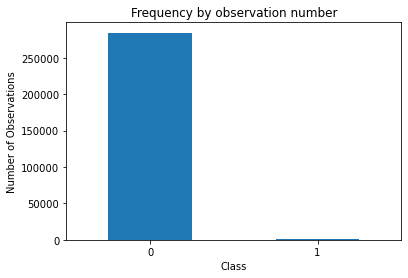

In [6]:
# Visualize the distribution of classes in the dataset
count_classes = pd.value_counts(dataset['Class'],sort=True) # sorts the counts in descending order
count_classes.plot(kind='bar',rot=0)
plt.xticks(range(len(dataset['Class'].unique())),dataset.Class.unique()) # customizes the x-axis ticks (labels) of the bar plot
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations")

In [7]:
#Save the normal and fradulent transcations in seperate dataframe
normal_dataset = dataset[dataset.Class == 0]
fraud_dataset = dataset[dataset.Class == 1]

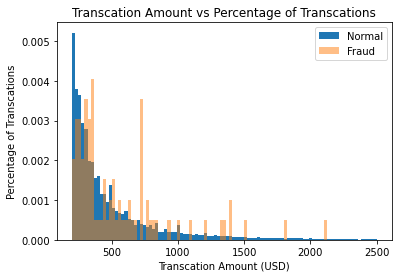

In [8]:
#Visualize transcation amounts for normal and fraudulent transcations

bins = np.linspace(200,2500,100) # define the ranges in which the transaction amounts will be grouped for visualization. with the total of the 100 Bins
plt.hist(normal_dataset.Amount,bins=bins,alpha=1,density=True,label='Normal')
plt.hist(fraud_dataset.Amount,bins=bins,alpha=0.5,density=True,label='Fraud')
plt.legend(loc='upper right')
plt.title("Transcation Amount vs Percentage of Transcations")
plt.xlabel("Transcation Amount (USD)")
plt.ylabel("Percentage of Transcations")
plt.show()

In [9]:
dataset

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [10]:
# Standardize 'Time' and 'Amount' columns
 
sc = StandardScaler() # creates an instance of the StandardScaler class 
dataset['Time'] = sc.fit_transform(dataset['Time'].values.reshape(-1,1)) # reshapes the 'Time' values into a two-dimensional array
dataset['Amount'] = sc.fit_transform(dataset['Amount'].values.reshape(-1,1))

# -1 is like a placeholder that tells Python to figure out how many rows are needed to keep the data in order. 
# The 1 specifies that there's only one column.
# transforming the data in such a way that it has a mean of 0 and a standard deviation of 1. 

In [11]:
# Split the data into train and test sets

raw_data = dataset.values

# The last column (column at index -1) typically contains information about whether a transaction is normal or fraud . 
labels = raw_data[:,-1]

# Includes all the columns except the last one (hence, 0:-1)
data = raw_data[:,0:-1]

train_data,test_data,train_labels,test_labels = train_test_split(data,labels,test_size = 0.2,random_state =2021) # ensures that the same split is reproducible if you run the code again.

In [12]:
# Normalize the data

min_val = tf.reduce_min(train_data) #  calculates the minimum value (the smallest element) in the train data 
max_val = tf.reduce_max(train_data) # calculates the maximum value (the largest element) in the 'train_data' 
 
#  transforms the data so that it falls within the range of 0 to 1.
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

# Type casting the datatype to the floating point number
train_data = tf.cast(train_data,tf.float32)
test_data = tf.cast(test_data,tf.float32)

# the labels to boolean (bool) format is typically done to prepare them for binary classification tasks where you have two classes, such as "normal" and "fraud.
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

In [13]:
# Create separate datasets for normal and fraud data
normal_train_data = train_data[~train_labels] # selecting data points for both normal and fraudulent transactions based on the corresponding boolean labels.
normal_test_data = test_data[~test_labels]

fraud_train_data = train_data[train_labels]
fraud_test_data = test_data[test_labels]
print("No. of records in Fraud Train Data=",len(fraud_train_data))
print("No. of records in Normal Train Data=",len(normal_train_data))
print("No. of records in Fraud Test Data=",len(fraud_test_data))
print("No. of records in Normal Test Data=",len(normal_test_data))

No. of records in Fraud Train Data= 389
No. of records in Normal Train Data= 227456
No. of records in Fraud Test Data= 103
No. of records in Normal Test Data= 56859


# Build the autoencoder model

In [14]:
nb_epoch = 50 # number of times the entire training dataset will be fed through the neural network during training.
batch_size = 64 # A batch size of 64 means that 64 data points will be processed at a time.
input_dim = normal_train_data.shape[1] # calculates the input dimension of the neural network
encoding_dim = 14 # number of neurons in the middle layer of an autoencoder neural network. with the total of 14 layers & 14 neurons
hidden_dim1 = int(encoding_dim / 2) # calculates the number of neurons in the first hidden layer
hidden_dim2 = 4 # number of neurons in the second hidden layer
learning_rate = 1e-7 #  1e-7, means smaller steps during training

Define the layers of the autoencoder


In [15]:
#input layer
input_layer = tf.keras.layers.Input(shape=(input_dim,)) # input_dim is the number of input features

#Encoder : It is responsible for reducing the dimensionality of the input data and capturing its essential features.
encoder = tf.keras.layers.Dense(encoding_dim,activation="tanh",activity_regularizer = tf.keras.regularizers.l2(learning_rate))(input_layer)
encoder = tf.keras.layers.Dropout(0.2)(encoder) #  randomly deactivates a fraction of neurons during training to prevent overfitting.
encoder = tf.keras.layers.Dense(hidden_dim1,activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim2,activation=tf.nn.leaky_relu)(encoder)

#Decoder : It aims to reconstruct the input data from the lower-dimensional representation.
decoder = tf.keras.layers.Dense(hidden_dim1,activation='relu')(encoder)
decoder = tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(encoding_dim,activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim,activation='tanh')(decoder)

#Autoencoder
autoencoder = tf.keras.Model(inputs = input_layer,outputs = decoder) # This line creates the full autoencoder model, connecting the input layer to the decoder. 

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 14)                434       
                                                                 
 dropout (Dropout)           (None, 14)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 4)                 32        
                                                                 
 dense_3 (Dense)             (None, 7)                 35        
                                                                 
 dropout_1 (Dropout)         (None, 7)                 0     

'''The output you provided is a summary of the autoencoder model architecture, which displays the layers, their types, output shapes, and the number of parameters. Let's break down the summary and explain its components:

1. **Model Name**:
   - `Model: "model"`: This indicates the name of the model. In this case, it's simply named "model."

2. **Layer Information**:
   - The summary provides information about each layer in the model. Let's go through them one by one:

   - **Input Layer**:
     - `input_1 (InputLayer)`: This is the input layer named "input_1," and it specifies the input shape as `(None, 30)`, where `30` is the number of input features.

   - **Encoder Layers**:
     - `dense (Dense)`: The first layer is a dense layer with output shape `(None, 14)`, and it has 434 parameters.
     - `dropout (Dropout)`: A dropout layer with output shape `(None, 14)`. Dropout layers have no trainable parameters, so they are shown as having 0 parameters.
     - `dense_1 (Dense)`: The second encoder layer with output shape `(None, 7)` and 105 parameters.
     - `dense_2 (Dense)`: The third encoder layer with output shape `(None, 4)` and 32 parameters.

   - **Decoder Layers**:
     - `dense_3 (Dense)`: The first decoder layer with output shape `(None, 7)` and 35 parameters.
     - `dropout_1 (Dropout)`: Another dropout layer with output shape `(None, 7)` and 0 parameters.
     - `dense_4 (Dense)`: The second decoder layer with output shape `(None, 14)` and 112 parameters.
     - `dense_5 (Dense)`: The final decoder layer with output shape `(None, 30)` and 450 parameters.

3. **Total and Trainable Parameters**:
   - `Total params: 1168 (4.56 KB)`: This section shows the total number of parameters in the model, which is 1168, and the approximate size of the model in kilobytes (KB).
   - `Trainable params: 1168 (4.56 KB)`: This indicates that all the parameters are trainable and will be updated during training.
   - `Non-trainable params: 0 (0.00 Byte)`: There are no non-trainable parameters in this model.

In summary, the model consists of an encoder-decoder architecture, where the encoder reduces the dimensionality of the input data, and the decoder attempts to reconstruct the original data. The total number of parameters is 1168, and all of them are trainable. The summary provides a useful overview of the model's architecture and its size.'''

In [16]:
# Compile the autoencoder model

cp = tf.keras.callbacks.ModelCheckpoint(filepath="autoencoder_fraud.h5",mode='min',monitor='val_loss',verbose=2,save_best_only=True)
#Define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                min_delta=0.0001,
                patience=10,
                verbose=11,
                mode='min',
                restore_best_weights=True
)

'''
tf.keras.callbacks.ModelCheckpoint is used to save the model's weights during training based on specific conditions.
filepath="autoencoder_fraud.h5  specifies the file path where the model weights will be saved. In this case, the model will be saved to a file named "autoencoder_fraud.h5."
mode='min' meaning the model will be saved when the monitored quantity (validation loss) is at its minimum.
monitor='val_loss': This is the quantity to monitor during training. The model checkpoints will be saved based on the validation loss.
verbose=2: This controls the verbosity of the output during training. A value of 2 means it will print more information about the checkpointing process.
save_best_only=True: If this is set to True, the model will save only the best model (based on the monitored quantity, in this case, the lowest validation loss). It ensures that you have the best model weights saved.
'''


'''
tf.keras.callbacks.EarlyStopping is used to stop training early based on specific conditions.
monitor='val_loss': It specifies the quantity to monitor during training. Training will be stopped if the validation loss stops decreasing significantly.
min_delta=0.0001: This parameter defines the minimum change in the monitored quantity (validation loss in this case) to be considered as an improvement. If the validation loss doesn't decrease by at least this amount, training may stop.
patience=10: This parameter determines how many epochs to wait before stopping the training if the monitored quantity doesn't improve. In this case, training will stop if there is no improvement for 10 consecutive epochs.
verbose=11: This controls the verbosity of the output during training. A value of 11 means it will print more information when early stopping is triggered.
mode='min': Similar to the ModelCheckpoint, this specifies that early stopping should be based on minimizing the monitored quantity (validation loss).
restore_best_weights=True: If set to True, the callback will restore the model to its best weights when early stopping is triggered.
'''

In [17]:
# configures the autoencoder model for training by specifying the loss function, optimizer, and metrics
autoencoder.compile(metrics=['accuracy'],loss= 'mean_squared_error',optimizer='adam')

# Train the autoencoder model


'''
callbacks=[cp, early_stop]: It specifies the callbacks to be applied during training. In this case, it uses the ModelCheckpoint (cp) and EarlyStopping (early_stop) callbacks, which were defined earlier. These callbacks save the best model and stop training early if certain conditions are met.

.history: The .history attribute stores training history, including loss and metrics, which can be used for analysis and visualization.
'''

In [18]:
history = autoencoder.fit(normal_train_data,normal_train_data,epochs = nb_epoch,
                         batch_size = batch_size,shuffle = True,
                         validation_data = (test_data,test_data),
                         verbose=1,
                         callbacks = [cp,early_stop]).history

# verbose=1 : controls the verbosity of the training output. A value of 1 means that training progress and statistics will be displayed during training.

Epoch 1/50
3551/3554 [============================>.] - ETA: 0s - loss: 0.0040 - accuracy: 0.0438
Epoch 1: val_loss improved from inf to 0.00004, saving model to autoencoder_fraud.h5
3554/3554 [==============================] - 33s 8ms/step - loss: 0.0040 - accuracy: 0.0438 - val_loss: 4.4813e-05 - val_accuracy: 0.0037
Epoch 2/50
   1/3554 [..............................] - ETA: 30s - loss: 1.4634e-05 - accuracy: 0.0312

C:\Users\SHUBHAM\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3552/3554 [============================>.] - ETA: 0s - loss: 1.9917e-05 - accuracy: 0.0636
Epoch 2: val_loss improved from 0.00004 to 0.00002, saving model to autoencoder_fraud.h5
3554/3554 [==============================] - 27s 8ms/step - loss: 1.9918e-05 - accuracy: 0.0636 - val_loss: 2.1748e-05 - val_accuracy: 0.0010
Epoch 3/50
3547/3554 [============================>.] - ETA: 0s - loss: 1.9579e-05 - accuracy: 0.0642
Epoch 3: val_loss improved from 0.00002 to 0.00002, saving model to autoencoder_fraud.h5
3554/3554 [==============================] - 27s 8ms/step - loss: 1.9576e-05 - accuracy: 0.0641 - val_loss: 2.0085e-05 - val_accuracy: 0.0596
Epoch 4/50
3552/3554 [============================>.] - ETA: 0s - loss: 1.9529e-05 - accuracy: 0.0595
Epoch 4: val_loss improved from 0.00002 to 0.00002, saving model to autoencoder_fraud.h5
3554/3554 [==============================] - 27s 7ms/step - loss: 1.9527e-05 - accuracy: 0.0595 - val_loss: 2.0045e-05 - val_accuracy: 0.0111
Epoch 5/50
3

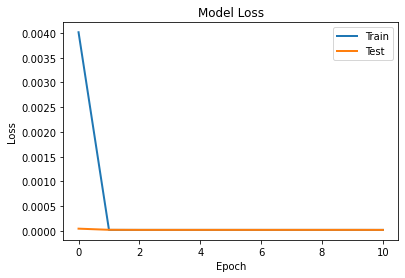

In [19]:
# # Visualize the loss during training

plt.plot(history['loss'],linewidth = 2,label = 'Train')
plt.plot(history['val_loss'],linewidth = 2,label = 'Test')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

Anomaly Detection and Evaluation

'''
 It compares the original test data (test_data) with the reconstructed data (test_x_predictions) and 
 computes the squared differences. Then, it takes the mean along axis=1 to calculate the MSE for each data point.
 The MSE is a measure of how well the autoencoder is able to reconstruct the input data. 
 A higher MSE indicates a larger reconstruction error.
'''

In [20]:
test_x_predictions = autoencoder.predict(test_data)
mse = np.mean(np.power(test_data - test_x_predictions, 2),axis = 1)
error_df = pd.DataFrame({'Reconstruction_error':mse,
                         'True_class':test_labels})

1781/1781 [==============================] - 7s 4ms/step


In [21]:
# Set a fixed threshold for anomaly detection

threshold_fixed = 52
pred_y = [1 if e > threshold_fixed else 0 
          for e in 
        error_df.Reconstruction_error.values]
error_df['pred'] = pred_y
conf_matrix = confusion_matrix(error_df.True_class,pred_y)


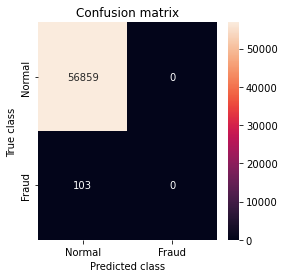

In [22]:
# Visualize the confusion matrix

plt.figure(figsize = (4,4))
sns.heatmap(conf_matrix,xticklabels = LABELS,yticklabels = LABELS,annot = True,fmt="d")
plt.title("Confusion matrix")
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.show()



In [23]:
#Print Accuracy,Precision and Recall
print("Accuracy :",accuracy_score(error_df['True_class'],error_df['pred']))
print("Recall :",recall_score(error_df['True_class'],error_df['pred']))
print("Precision :",precision_score(error_df['True_class'],error_df['pred']))

Accuracy : 0.9981917769741231
Recall : 0.0
Precision : 0.0


C:\Users\SHUBHAM\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
